In [56]:
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
import dill
import os
import pandas as pd
import numpy as np
import requests

from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output

output_notebook()

Loading BokehJS ...

In [57]:
code_dir = os.getcwd()
data_dir = code_dir.replace('code', 'data')

In [58]:
company_info = pd.read_csv(data_dir+'/companytickers.csv', usecols=['Ticker','Sector', 'Industry'])
# joined_data = dill.load(open(data_dir+'/ticker_secind_patnum_allyear.pkd', 'rb'))

In [59]:
body = pd.read_csv(data_dir+'/ee_or_matched.csv',index_col=0, dtype=str)
yearlydata = dill.load(open(data_dir+'/yearlydata.pkd', 'rb'))

In [60]:
def data_by_year(min_year, max_year, df=body, col_name='exec_dt'):
    lower = df[pd.to_datetime(df[col_name])>pd.to_datetime(min_year)]
    data = lower[pd.to_datetime(lower[col_name])<pd.to_datetime(max_year)]
    return data

def update_data_year(*args):
    data_year = data_by_year(df=body, 
                             min_year=str(slider.value[0]), 
                             max_year=str(slider.value[1]))
    return data_year

In [61]:
def plot_by_range(df, min_year, max_year):
    body_filtered = data_by_year(min_year, max_year, df=yearlydata)
    x = list(body_filtered.iloc[:,0].astype(int))
    y = list(body_filtered.iloc[:,1])
        
    p = figure(title="Yearly Patent Assignment Number", plot_height=300, plot_width=600)
    r = p.vbar(x=x,width=0.5, top=y)

    show(p, notebook_handle=True)
    
def update_plot_by_range(*args):
    clear_output()
    plot_by_range(df, min_year=str(slider.value[0]), max_year=str(slider.value[1]))

In [62]:
slider = widgets.IntRangeSlider(
    value=[2008, 2018],
    min=1954,
    max=2018,
    step=1,
    description='Year Range:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='i',
    slider_color='white',
    color='black',
    layout={'width': '60%'}
)

df = yearlydata
slider.observe(handler=update_plot_by_range, names='value')
display(slider)

In [ ]:
slider.observe(handler=update_data_year, names='value')
data_year = update_data_year()
# data_year.head()

In [ ]:
def top_group(df, groupbyname, sortbyname, topnum):
    raw = df[[groupbyname, sortbyname]].groupby(groupbyname).nunique()
    top = raw.sort_values(by=sortbyname, ascending=False)[:topnum]
    return top

In [5]:
groupbysec = pd.DataFrame(joined_data.groupby(['Sector'])['grant_doc_num'].sum())
groupbysec = groupbysec.sort_values(by='grant_doc_num',ascending=False).reset_index()
sectorlist = list(groupbysec['Sector'])
sectornum = list(groupbysec['grant_doc_num'])

In [ ]:
from bokeh.models import NumeralTickFormatter
from bokeh.models import FuncTickFormatter
from bokeh.models import SingleIntervalTicker, LinearAxis
from bokeh.models.tickers import FixedTicker

label_dict = {}
for i, s in enumerate(sectorlist):
    label_dict[i] = s
    
p2 = figure(title='Num. of Patent Assignment by Sector: year {} to {}'.format(slider.value[0], slider.value[1]), 
            plot_height=400, plot_width=600)    
r2 = p2.hbar(y=np.arange(len(sectorlist)), height=0.5, right=sectornum)
p2.xaxis.formatter = NumeralTickFormatter(format="0")
p2.xaxis.major_label_orientation = 45
p2.yaxis.ticker = FixedTicker(ticks=np.arange(len(sectorlist)))
p2.yaxis.formatter = FuncTickFormatter(code="""
    var labels = %s;
    return labels[tick];
""" % label_dict)

show(p2, notebook_handle=True)

In [ ]:
def sector_plot(data_year, sector, topnum):
    sec_tickers = list(company_info[company_info['Sector']==sector]['Ticker'])
    sectordf = data_year[data_year['ticker'].isin(sec_tickers)]
    topgroup = top_group(sectordf, 'ticker', 'grant_doc_num', topnum)
    topgroup = topgroup.drop('ticker', axis=1)
    topgroup = topgroup.reset_index()
    x = list(topgroup.iloc[:,0])
    y = list(topgroup.iloc[:,1])
        
    label_dict = {}
    for i, s in enumerate(x):
        label_dict[i] = s
        
    p3 = figure(title='Patent Distribution: {} year {} to {}'.format(sector, slider.value[0], slider.value[1]))    
    r3 = p3.hbar(y=np.arange(len(x)), height=0.5, right=y)
    p3.yaxis.ticker = FixedTicker(ticks=np.arange(len(x)))
    p3.yaxis.formatter = FuncTickFormatter(code="""
        var labels = %s;
        return labels[tick];
    """ % label_dict)
    show(p3, notebook_handle=True)
    
    
def update_sector_plot(*args):
    clear_output()
    sector_plot(data_year, sector=select_sector.value[0], topnum=topnum.value)
    
def update_companylist(*args):
    sec_tickers = list(company_info[company_info['Sector']==select_sector.value[0]]['Ticker'])
    sectordf = data_year[data_year['ticker'].isin(sec_tickers)]
    companylist = list(top_group(sectordf, 'ticker', 'grant_doc_num', topnum.value).index)
    return companylist

In [ ]:
topnum = widgets.IntSlider(min=0,
                           max=50,
                           step=2,
                           value=20,
                           description='Top Companies to Show:',
                           disabled=False,
                           continuous_update=True,
                           orientation='horizontal',
                           readout=True,
                           readout_format='d',
                           layout={'width': '50%'})

select_sector = widgets.SelectMultiple(options=sectorlist, 
                                       value=(sectorlist[0],),
                                       description='Select Sector:',
                                       disabled=False)


select_sector.observe(handler=update_sector_plot, names='value')
topnum.observe(handler=update_sector_plot, names='value')
select_sector.observe(handler=update_companylist, names='value')
topnum.observe(handler=update_companylist, names='value')
companylist = update_companylist()

sector_plot(data_year, sectorlist[0], 20)

display(topnum)
display(select_sector)

# Test Clustering for Sectors

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [5]:
from string import punctuation
from collections import Counter
import random

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pprint import pprint

In [ ]:
def process_text(text):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = [wordnet_lemmatizer.lemmatize(t, pos='n') for t in tokens]
    return tokens


def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'),
                                 lowercase=True)

    tfidf_model = vectorizer.fit_transform(texts)

    km_model = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=5)
    km_model.fit(tfidf_model)
    
    order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    
    return order_centroids, terms

In [ ]:
tokened_titles = dill.load(open(data_dir+'/#tokened_titles.pkd', 'rb'))
sub_body = tokened_titles[['exec_dt','or_name','title','ee_name_matched','ticker']]

In [10]:
sub_body.shape

(1377018, 5)

In [11]:
title_list = sub_body['title'].tolist()
title_list = [' '.join(w) for w in title_list]
sub_body['title'] = title_list

/Users/annzhong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
sub_body = sub_body.drop_duplicates(subset='title')

In [13]:
sub_body.shape

(427758, 5)

In [68]:
sub_body.head()

,exec_dt,or_name,title,ee_name_matched,ticker,sector,title_stem
0,1980-08-01,"DOMAIN INDUSTRIES, INC.,","[bag, making, machine]",NORDSON CORPORATION,NDSN,Information Technology,"[bag, make, machin]"
2,1980-08-01,"DOMAIN INDUSTRIES, INC.,","[rotary, piston, filler]",NORDSON CORPORATION,NDSN,Information Technology,"[rotari, piston, filler]"
4,1980-09-25,ROOD ALVIN A.,"[method, manufacturing, airless, spray, nozzle]",NORDSON CORPORATION,NDSN,Information Technology,"[method, manufactur, airless, spray, nozzl]"
6,1980-09-25,PRICE RICHARD P.,"[method, apparatus, producing, foam, viscous, ...",NORDSON CORPORATION,NDSN,Information Technology,"[method, apparatu, produc, foam, viscou, liquid]"
10,1980-10-20,HASTINGS DONALD R.,"[nozzle, assembly, spray, coating, systems]",NORDSON CORPORATION,NDSN,Information Technology,"[nozzl, assembl, spray, coat, system]"


In [ ]:
# company_info[['Ticker', 'Sector']]
keys = company_info['Ticker']
values = company_info['Sector']
ticker_sector_dictionary = dict(zip(keys, values))

sub_body['sector'] = sub_body['ticker'].map(ticker_sector_dictionary)
sub_body['title'] = sub_body['title'].apply(lambda x: word_tokenize(x.lower()))
title_list = sub_body['title'].tolist()

In [71]:
title_list = sub_body['title'].tolist()
title_list[:2]

[['bag', 'making', 'machine'], ['rotary', 'piston', 'filler']]

In [72]:
lemma_titles = []
lemma = WordNetLemmatizer()
for titles in title_list:
    tokens = list(filter(lambda x: x not in punctuation, titles))
    tokens = [lemma.lemmatize(token) for token in tokens]
    lemma_titles.append(tokens)

In [74]:
# lemma_titles

In [75]:
sub_body['title_lemma'] = lemma_titles

In [76]:
# sub_body.to_pickle(data_dir+'/#patent_title_lemma.pkd')

In [82]:
# sub_body.to_pickle(data_dir+'/patent_title_stemmed.pkd')
# sub_body = dill.load(open(data_dir+'/#patent_title_stemmed.pkd', 'rb'))
# sub_body['title'] == sub_body['title_lemma']
# sub_body[sub_body['title'] != sub_body['title_lemma']][['title','title_lemma']]

In [35]:
sub_body.shape

(427758, 7)

In [37]:
# sub_body.drop_duplicates(subset='title')

In [7]:
# count the key words in a sector
def count_keywords(sector):
    titles = list(sub_body[sub_body['sector'] == sector]['title_stem'])
    alltokens = [item for sublist in titles for item in sublist]
    counter = Counter(alltokens)
    
    return counter.most_common(10)

In [8]:
sectorlist = list(set(company_info['Sector']))

keywords = {}
for sector in sectorlist:
    keywords[sector]=count_keywords(sector)

In [32]:
# keywords
# del keywords['<Unclassified>']
# pd.DataFrame(keywords).to_csv(data_dir+'/keywords_in_sectors.csv')

# TF-IDF calculations

Test with small samples first
 - 30% sample size

In [12]:
sectorlist

['Consumer Staples',
 'Information Technology',
 'Raw & Intermediate Materials',
 'Utilities',
 'Financials',
 'Energy',
 'Consumer Cyclicals',
 'Industrials',
 'Healthcare',
 'Telecom Services',
 '<Unclassified>']

In [9]:
consumer_cyclicals = sub_body[sub_body['sector'] == 'Consumer Cyclicals']

In [10]:
titles_token = consumer_cyclicals['title_stem'].tolist()
titles = []
for token in titles_token:
    titles.append(' '.join(token))

In [12]:
consumer_cyclicals.shape

(9330, 7)

In [13]:
consumer_cyclicals['title'] = titles
consumer_cyclicals = consumer_cyclicals.drop_duplicates(subset='title')

/Users/annzhong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
consumer_cyclicals.shape

(9066, 7)

In [15]:
titles = consumer_cyclicals['title'].tolist()

In [16]:
vectorizer = TfidfVectorizer(min_df=10, max_df=10000, ngram_range=(2,2))
tfidf_model = vectorizer.fit_transform(titles)

In [17]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

visualization of tfidf score distribution

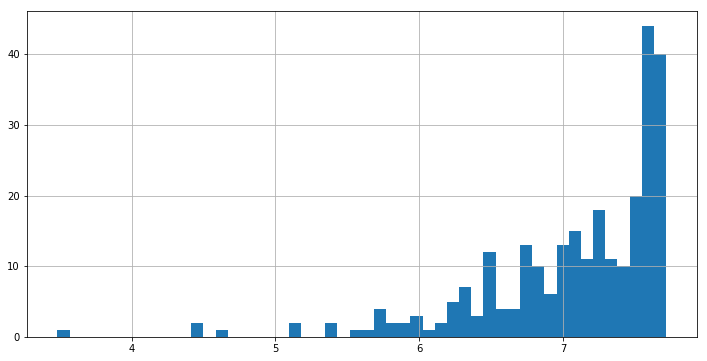

In [19]:
tfidf.tfidf.hist(bins=50, figsize=(12,6))

In [49]:
# 30 tokens that have the lowest tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
system method,3.484355
method apparatu,4.418665
method system,4.432224
heat exchang,4.648565
marin propuls,5.101761
control system,5.163637
program guid,5.350223
apparatu method,5.421049
method make,5.537686
marin vessel,5.658049


In [50]:
# 30 words with the highest tfidf scores.
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
actuat system,7.714501
light control,7.714501
devic marin,7.714501
display mirror,7.714501
equip vehicl,7.714501
evapor foam,7.714501
fantasi sport,7.714501
flat tube,7.714501
high speed,7.714501
induct system,7.714501


In [20]:
from sklearn.decomposition import TruncatedSVD

In [21]:
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(tfidf_model)

In [22]:
svd_tfidf

array([[  8.28528343e-04,   1.23159993e-02,   1.93310814e-04, ...,
          5.39742246e-03,   4.50885860e-03,   2.08227436e-03],
       [  1.53637676e-03,   2.24615022e-02,   3.51839348e-04, ...,
          4.93096594e-03,  -1.69770244e-03,  -1.76215217e-03],
       [  1.53637676e-03,   2.24615022e-02,   3.51839348e-04, ...,
          4.93096594e-03,  -1.69770244e-03,  -1.76215217e-03],
       ..., 
       [ -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00, ...,
         -0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.94551342e-01,  -5.29475133e-03,  -2.53496227e-03, ...,
          3.51773609e-03,   2.05203099e-04,  -1.22237209e-02],
       [ -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00, ...,
         -0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

### further reduce using PCA

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_tfidf = pca.fit_transform(svd_tfidf)

In [28]:
pca.explained_variance_ratio_.sum()

0.2051428534277292

In [29]:
pca_tfidf.shape

(9066, 2)

In [26]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

In [30]:
output_notebook()
plot_tfidf = bp.figure(plot_width=500, plot_height=500, title="tf-idf clustering of patent titles",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [31]:
tfidf_df = pd.DataFrame(pca_tfidf, columns=['x', 'y'])
tfidf_df['title'] = titles

In [32]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"title": "@title"}
show(plot_tfidf)

# Kmeans clustering

In [33]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.cluster import MiniBatchKMeans

In [34]:
num_clusters = 5
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(tfidf_model)
kmeans_clusters = kmeans.predict(tfidf_model)
kmeans_distances = kmeans.transform(tfidf_model)

In [35]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

Cluster 0:
mobil robot | manag system | method use | system remot | system includ | remot control | system method | method oper | method system | commun system | 

Cluster 1:
marin propuls | propuls system | propuls devic | system marin | propuls unit | cool system | system method | method control | outboard marin | system automat | 

Cluster 2:
system method | method apparatu | method system | heat exchang | control system | apparatu method | method make | program guid | method provid | outboard motor | 

Cluster 3:
circuit board | method make | multi lay | gp receiv | method form | assembl method | fuel tank | global navig | global posit | gnss signal | 

Cluster 4:
busi form | method make | secur document | wireless commun | gnss signal | fuel system | fuel tank | global navig | global posit | gp receiv | 



In [81]:
kmeans_distances.shape

(9066, 5)

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, learning_rate=30, n_iter=300)
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

In [84]:
tsne_kmeans.shape

(9066, 2)

In [37]:
colormap = np.array(["#7fc97f", "#beaed4", "#fdc086", "#ffff99", "#386cb0"])

plot_kmeans = bp.figure(plot_width=500, plot_height=500, title="KMeans clustering of consumer cyclicals",
    tools="pan,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [38]:
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['title'] = titles

In [49]:
Counter(kmeans_clusters)

Counter({0: 31, 1: 153, 2: 8829, 3: 17, 4: 36})

In [39]:
plot_kmeans.scatter(x='x', y='y', 
                    color=colormap[kmeans_clusters], 
                    source=kmeans_df)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"title": "@title", "cluster":"@cluster"}
show(plot_kmeans)

# Latent Dirichlet Allocation (with Bokeh)

In [51]:
import lda
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [53]:
cvectorizer = CountVectorizer(min_df=4, max_features=10000, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(consumer_cyclicals['title'])

n_topics = 5
n_iter = 100
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

In [55]:
n_top_words = 8
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: system posit use receiv light method apparatu signal
Topic 1: system marin motor devic vehicl propuls marin propuls guid
Topic 2: system control engin method air marin fuel system method
Topic 3: method system system method vehicl apparatu method system data devic
Topic 4: method heat exchang heat exchang assembl apparatu make use
